In [ ]:
# Import necessary libraries
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from datasets import load_dataset
import numpy as np
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr.client import NumPyClient
from flwr.common import Context, NDArrays, Scalar, ndarrays_to_parameters, EvaluateRes
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from collections import OrderedDict
from typing import Dict, Tuple, List
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from flwr.server.client_proxy import ClientProxy
from flwr.common.logger import log
from logging import INFO

# Additional imports for plotting and data saving
import matplotlib.pyplot as plt
import pandas as pd
import random
import os


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Define constants
NUM_CLIENTS = 5
NUM_ROUNDS = 50
BATCH_SIZE = 32

# We will define the number of attackers per scenario in the function

# We will define whether to use IID or non-IID data per scenario in the function

# Function to run simulation for a given scenario
def run_simulation_scenario(ATTACKER_IDS, USE_IID):
    # Define partitioner based on IID or non-IID
    if USE_IID:
        # IID Partitioning
        partitioner = IidPartitioner(num_partitions=NUM_CLIENTS)
    else:
        # Non-IID Partitioning using Dirichlet distribution
        alpha = 1.0  # Adjust alpha for desired heterogeneity
        partitioner = DirichletPartitioner(num_partitions=NUM_CLIENTS, alpha=alpha, partition_by="label")

    # Load the CIFAR-10 dataset and partition it
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": partitioner})

    def get_cifar10_dataloaders(cifar10_dataset, batch_size: int):
        """
        Function to handle CIFAR-10 data loaders.
        Applies appropriate transformations for CIFAR-10 images.
        """
        # CIFAR-10 normalization parameters
        pytorch_transforms = Compose([
            ToTensor(),
            Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

        # Prepare transformation functions
        def apply_transforms(batch):
            """Apply transforms to the partition from FederatedDataset."""
            batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
            return batch

        cifar10_dataset = cifar10_dataset.with_transform(apply_transforms)

        # Construct PyTorch dataloader
        dataloader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True)
        return dataloader

    # Define the neural network model suitable for CIFAR-10
    class Net(nn.Module):
        def __init__(self, num_classes: int) -> None:
            super(Net, self).__init__()
            self.conv1 = nn.Conv2d(3, 6, 5)  # Changed input channels from 1 to 3 for CIFAR-10
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Adjusted for 32x32 images
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(-1, 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Functions to set and get model parameters
    def set_params(model, parameters):
        """Replace model parameters with those passed as parameters."""
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

    def get_params(model):
        """Extract model parameters as a list of NumPy arrays."""
        return [val.cpu().numpy() for _, val in model.state_dict().items()]

    # Training function with label flipping for attackers
    def train(net, trainloader, optimizer, device="cpu", is_attacker=False):
        """Train the network on the training set."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.train()
        for batch in trainloader:
            images, labels = batch["img"].to(device), batch["label"].to(device)
            optimizer.zero_grad()
            if is_attacker:
                # Flip labels for attackers (simple label flipping)
                labels = (labels + 1) % 10
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Testing function with metric calculations
    def test(net, testloader, device):
        """Validate the network on the entire test set."""
        criterion = torch.nn.CrossEntropyLoss()
        net.to(device)
        net.eval()
        correct, loss = 0, 0.0
        all_preds = []
        all_labels = []
        all_outputs = []
        with torch.no_grad():
            for batch in testloader:
                images, labels = batch["img"].to(device), batch["label"].to(device)
                outputs = net(images)
                loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_outputs.extend(outputs.cpu().numpy())
        accuracy = correct / len(testloader.dataset)

        # Compute metrics
        kappa = cohen_kappa_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')

        # Check if there are at least two classes in y_true
        unique_classes = np.unique(all_labels)
        if len(unique_classes) > 1:
            try:
                all_labels_bin = label_binarize(all_labels, classes=list(range(10)))
                all_outputs_array = np.array(all_outputs)
                roc_auc = roc_auc_score(all_labels_bin, all_outputs_array, average='macro', multi_class='ovr')
            except ValueError:
                roc_auc = float('nan')  # Assign NaN if ROC AUC cannot be computed
        else:
            roc_auc = float('nan')  # Assign NaN if only one class is present

        metrics = {
            "accuracy": accuracy,
            "kappa": kappa,
            "f1_score": f1,
            "roc_auc": roc_auc,
        }
        return loss, accuracy, metrics

    # Initialize metrics lists
    rounds_list = []
    accuracy_list = []
    kappa_list = []
    f1_list = []
    roc_auc_list = []

    # Define the FlowerClient class
    class FlowerClient(NumPyClient):
        def __init__(self, trainloader, valloader, is_attacker=False) -> None:
            super().__init__()
            self.trainloader = trainloader
            self.valloader = valloader
            self.model = Net(num_classes=10)
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            self.is_attacker = is_attacker

        def fit(self, parameters, config):
            """Train the model locally."""
            # Set model parameters
            set_params(self.model, parameters)

            # Define the optimizer
            optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

            # Train the model
            train(self.model, self.trainloader, optim, self.device, is_attacker=self.is_attacker)

            # Return updated parameters
            return get_params(self.model), len(self.trainloader.dataset), {}

        def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
            """Evaluate the model locally."""
            set_params(self.model, parameters)
            loss, accuracy, metrics = test(self.model, self.valloader, self.device)
            return float(loss), len(self.valloader.dataset), metrics

    # Define the client function
    def client_fn(context: Context):
        """Create a Flower client representing a participant in the federated learning."""
        partition_id = int(context.node_config["partition-id"])
        partition = fds.load_partition(partition_id, "train")
        # Partition into train/validation
        partition_train_val = partition.train_test_split(test_size=0.1, seed=42)
        # Get dataloaders
        trainloader = get_cifar10_dataloaders(partition_train_val["train"], batch_size=BATCH_SIZE)
        valloader = get_cifar10_dataloaders(partition_train_val["test"], batch_size=BATCH_SIZE)
        # Determine if the client is an attacker
        is_attacker = partition_id in ATTACKER_IDS
        return FlowerClient(trainloader=trainloader, valloader=valloader, is_attacker=is_attacker).to_client()

    # Define custom strategy to log metrics
    class CustomFedAvg(FedAvg):
        def __init__(self, *args, **kwargs):
            self.rounds_list = kwargs.pop('rounds_list')
            self.accuracy_list = kwargs.pop('accuracy_list')
            self.kappa_list = kwargs.pop('kappa_list')
            self.f1_list = kwargs.pop('f1_list')
            self.roc_auc_list = kwargs.pop('roc_auc_list')
            super().__init__(*args, **kwargs)

        def aggregate_evaluate(
            self,
            rnd: int,
            results: List[Tuple[ClientProxy, EvaluateRes]],
            failures: List[BaseException],
        ):
            """Aggregate evaluation results using weighted average and log metrics per round."""
            if not results:
                return None, {}

            # Use weighted average to aggregate metrics
            num_examples_total = sum([r[1].num_examples for r in results])

            # Initialize sums
            accuracy_sum = 0.0
            kappa_sum = 0.0
            f1_sum = 0.0
            roc_auc_sum = 0.0
            roc_auc_weight = 0

            for _, evaluate_res in results:
                accuracy_sum += evaluate_res.metrics.get("accuracy", 0.0) * evaluate_res.num_examples
                kappa_sum += evaluate_res.metrics.get("kappa", 0.0) * evaluate_res.num_examples
                f1_sum += evaluate_res.metrics.get("f1_score", 0.0) * evaluate_res.num_examples
                roc_auc = evaluate_res.metrics.get("roc_auc", float('nan'))
                if not np.isnan(roc_auc):
                    roc_auc_sum += roc_auc * evaluate_res.num_examples
                    roc_auc_weight += evaluate_res.num_examples

            # Compute weighted averages
            accuracy = accuracy_sum / num_examples_total
            kappa = kappa_sum / num_examples_total
            f1 = f1_sum / num_examples_total
            roc_auc = roc_auc_sum / roc_auc_weight if roc_auc_weight > 0 else float('nan')

            # Log metrics
            log(INFO, f"Round {rnd} evaluation metrics:")
            log(INFO, f"Accuracy: {accuracy:.4f}")
            log(INFO, f"Kappa: {kappa:.4f}")
            log(INFO, f"F1 Score: {f1:.4f}")
            if not np.isnan(roc_auc):
                log(INFO, f"ROC AUC: {roc_auc:.4f}")
            else:
                log(INFO, f"ROC AUC: Undefined (only one class present in y_true)")

            # Store metrics
            self.rounds_list.append(rnd)
            self.accuracy_list.append(accuracy)
            self.kappa_list.append(kappa)
            self.f1_list.append(f1)
            self.roc_auc_list.append(roc_auc if not np.isnan(roc_auc) else 0.0)

            # Return aggregated loss and metrics
            return super().aggregate_evaluate(rnd, results, failures)

    # Define the server function
    def server_fn(context: Context):
        # Instantiate the model
        model = Net(num_classes=10)
        ndarrays = get_params(model)
        # Convert model parameters to flwr.common.Parameters
        global_model_init = ndarrays_to_parameters(ndarrays)

        # Define the strategy
        strategy = CustomFedAvg(
            fraction_fit=1.0,        # All clients participate in training
            fraction_evaluate=1.0,   # All clients participate in evaluation
            initial_parameters=global_model_init,  # Initialized global model
            rounds_list=rounds_list,
            accuracy_list=accuracy_list,
            kappa_list=kappa_list,
            f1_list=f1_list,
            roc_auc_list=roc_auc_list,
        )

        # Construct ServerConfig
        config = ServerConfig(num_rounds=NUM_ROUNDS)

        # Wrap everything into a ServerAppComponents object
        return ServerAppComponents(strategy=strategy, config=config)

    # Create your ServerApp and ClientApp
    server_app = ServerApp(server_fn=server_fn)
    from flwr.client import ClientApp
    client_app = ClientApp(client_fn=client_fn)

    # Run the simulation
    run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_name="ray",
        verbose_logging=True,
    )

    # After the simulation, collect the metrics
    metrics = {
        "rounds": rounds_list,
        "accuracy": accuracy_list,
        "kappa": kappa_list,
        "f1_score": f1_list,
        "roc_auc": roc_auc_list,
    }

    return metrics

# Function to run all scenarios
def run_all_scenarios():
    scenarios = [
        {"name": "Baseline_IID", "ATTACKER_IDS": [], "USE_IID": True},
        {"name": "One_Attacker_IID", "ATTACKER_IDS": [0], "USE_IID": True},
        {"name": "Two_Attackers_IID", "ATTACKER_IDS": [0, 1], "USE_IID": True},
        {"name": "Baseline_NonIID", "ATTACKER_IDS": [], "USE_IID": False},
        {"name": "One_Attacker_NonIID", "ATTACKER_IDS": [0], "USE_IID": False},
        {"name": "Two_Attackers_NonIID", "ATTACKER_IDS": [0, 1], "USE_IID": False},
    ]

    results = {}

    for scenario in scenarios:
        print(f"\nRunning Scenario: {scenario['name']}")
        metrics = run_simulation_scenario(scenario["ATTACKER_IDS"], scenario["USE_IID"])
        results[scenario["name"]] = metrics

        # Plot the metrics
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(metrics["rounds"], metrics["accuracy"], marker='o', color='blue')
        plt.title(f"Accuracy Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics["rounds"], metrics["kappa"], marker='o', color='green')
        plt.title(f"Kappa Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel('Kappa')
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics["rounds"], metrics["f1_score"], marker='o', color='red')
        plt.title(f"F1 Score Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("F1 Score")
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics["rounds"], metrics["roc_auc"], marker='o', color='purple')
        plt.title(f"ROC AUC Over Rounds ({scenario['name']})")
        plt.xlabel('Round')
        plt.ylabel("ROC AUC")
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Save metrics to CSV
        df = pd.DataFrame(metrics)
        df.to_csv(f"{scenario['name']}_metrics.csv", index=False)

    return results

# Run all scenarios
results = run_all_scenarios()


INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]



Running Scenario: Baseline_IID


INFO :      configure_fit: strategy sampled 2 clients (out of 5)
(ClientAppActor pid=500406) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
(ClientAppActor pid=500406)   obj.co_lnotab,  # for < python 3.10 [not counted in args]
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=500430) /home/fredrik/BTH/DV2607/part2/flower_env/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead. [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=500430)   obj.co_lnotab,  # for < python 3.10 [not counted in ar

In [ ]:
# Define the list of scenarios
scenarios = [
    "Baseline_IID",
    "One_Attacker_IID",
    "Two_Attackers_IID",
    "Baseline_NonIID",
    "One_Attacker_NonIID",
    "Two_Attackers_NonIID",
]

# Initialize a dictionary to store DataFrames
dataframes = {}

# Load each CSV file into a DataFrame
for scenario in scenarios:
    filename = f"{scenario}_metrics.csv"
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        dataframes[scenario] = df
        print(f"Loaded {filename} successfully.")
    else:
        print(f"Warning: {filename} does not exist and will be skipped.")

# Verify the loaded data
for scenario, df in dataframes.items():
    print(f"\nFirst few rows for {scenario}:")
    display(df.head())


Loaded Baseline_IID_metrics.csv successfully.
Loaded One_Attacker_IID_metrics.csv successfully.
Loaded Two_Attackers_IID_metrics.csv successfully.
Loaded Baseline_NonIID_metrics.csv successfully.
Loaded One_Attacker_NonIID_metrics.csv successfully.
Loaded Two_Attackers_NonIID_metrics.csv successfully.

First few rows for Baseline_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.3524,0.279820,0.320938,0.797937
1,2,0.4590,0.398782,0.450877,0.840030
2,3,0.4858,0.428599,0.475000,0.853391
3,4,0.5234,0.470240,0.518282,0.862007
4,5,0.5334,0.481749,0.530581,0.866066



First few rows for One_Attacker_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.1750,0.080267,0.127989,0.688551
1,2,0.4282,0.364312,0.403724,0.820818
2,3,0.4468,0.385572,0.431306,0.837420
3,4,0.4948,0.438469,0.490443,0.849024
4,5,0.5018,0.446971,0.500791,0.850105



First few rows for Two_Attackers_IID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.2486,0.166867,0.210834,0.718906
1,2,0.3632,0.292617,0.330902,0.778892
2,3,0.3704,0.301102,0.344118,0.809166
3,4,0.3894,0.322293,0.370690,0.813677
4,5,0.3910,0.323748,0.370304,0.813852



First few rows for Baseline_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.299620,0.216885,0.208196,0.783854
1,2,0.423346,0.348243,0.356943,0.818980
2,3,0.472117,0.402282,0.415894,0.839830
3,4,0.512493,0.447168,0.457147,0.861385
4,5,0.531081,0.468201,0.480332,0.869770



First few rows for One_Attacker_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.235059,0.146963,0.126476,0.716593
1,2,0.399560,0.321469,0.321254,0.815551
2,3,0.442534,0.368084,0.363773,0.837516
3,4,0.478913,0.408383,0.402893,0.851703
4,5,0.498101,0.430240,0.432091,0.857833



First few rows for Two_Attackers_NonIID:


,rounds,accuracy,kappa,f1_score,roc_auc
0,1,0.229662,0.139524,0.137296,0.735812
1,2,0.288227,0.199346,0.181657,0.761297
2,3,0.287228,0.197565,0.192338,0.773809
3,4,0.325805,0.240867,0.242312,0.788568
4,5,0.352189,0.268365,0.275848,0.802115


In [ ]:
# Combine all DataFrames into a single DataFrame for easier comparison
combined_df = pd.DataFrame()

for scenario, df in dataframes.items():
    temp_df = df.copy()
    temp_df['Scenario'] = scenario
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

# Display the combined DataFrame
print("Combined DataFrame:")
display(combined_df.head())


Combined DataFrame:


,rounds,accuracy,kappa,f1_score,roc_auc,Scenario
0,1,0.3524,0.279820,0.320938,0.797937,Baseline_IID
1,2,0.4590,0.398782,0.450877,0.840030,Baseline_IID
2,3,0.4858,0.428599,0.475000,0.853391,Baseline_IID
3,4,0.5234,0.470240,0.518282,0.862007,Baseline_IID
4,5,0.5334,0.481749,0.530581,0.866066,Baseline_IID


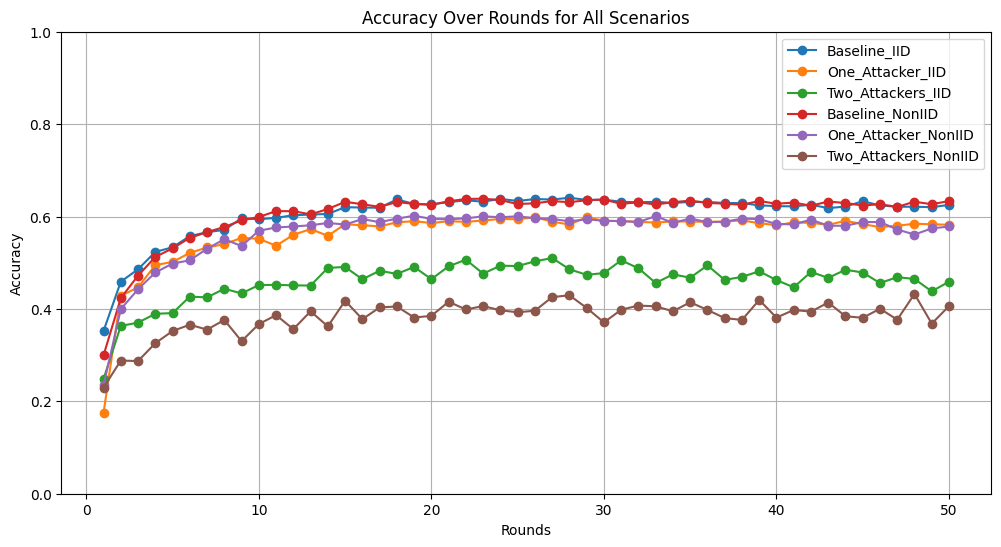

In [ ]:
# Plot Accuracy Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['accuracy'], marker='o', label=scenario)

plt.title('Accuracy Over Rounds for All Scenarios')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


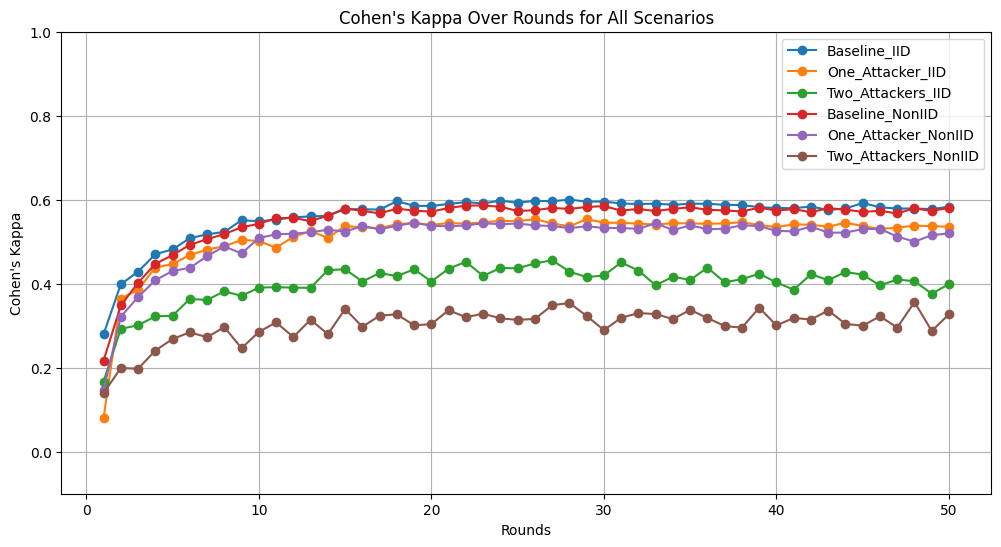

In [ ]:
# Plot Cohen's Kappa Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['kappa'], marker='o', label=scenario)

plt.title("Cohen's Kappa Over Rounds for All Scenarios")
plt.xlabel('Rounds')
plt.ylabel('Cohen\'s Kappa')
plt.ylim(-0.1, 1)
plt.grid(True)
plt.legend()
plt.show()


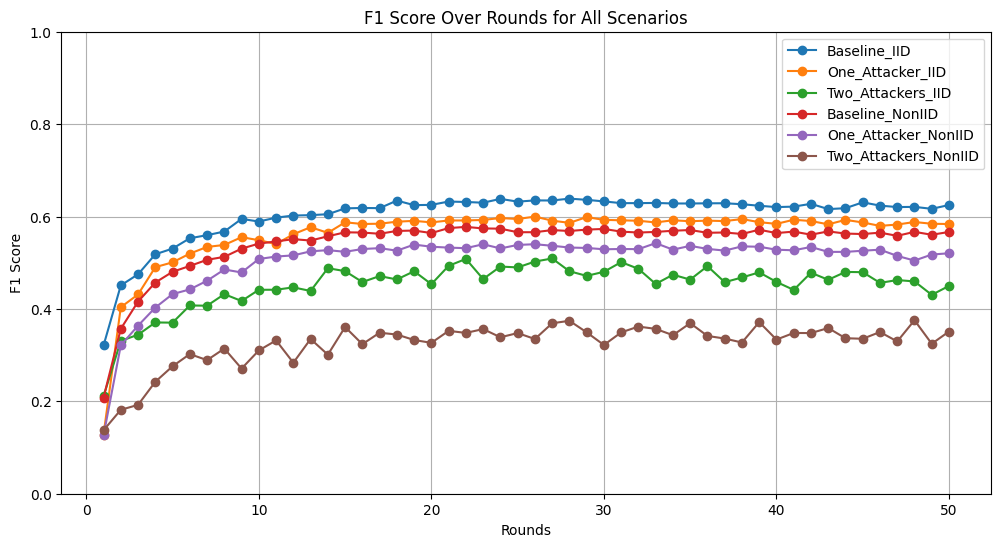

In [ ]:
# Plot F1 Score Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['f1_score'], marker='o', label=scenario)

plt.title('F1 Score Over Rounds for All Scenarios')
plt.xlabel('Rounds')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


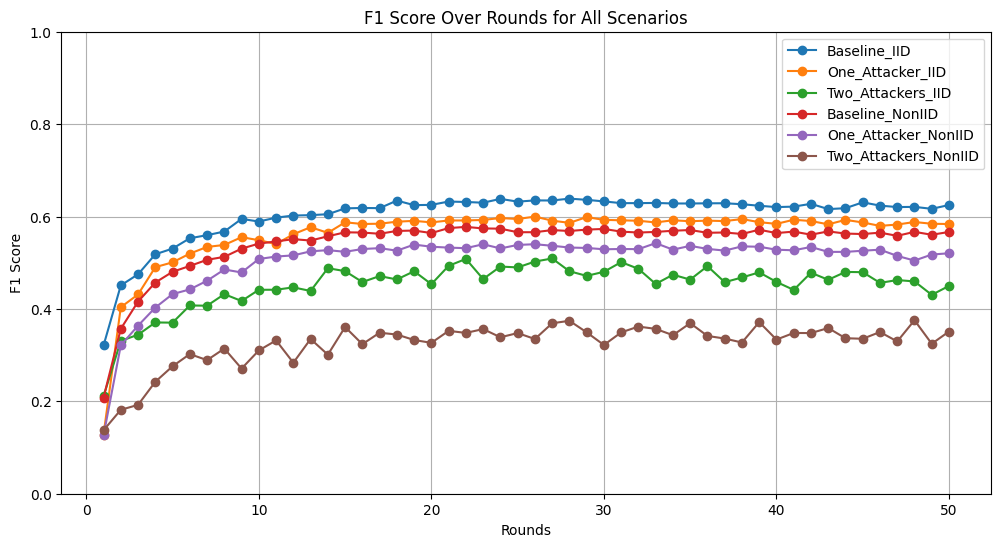

In [ ]:
# Plot F1 Score Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['f1_score'], marker='o', label=scenario)

plt.title('F1 Score Over Rounds for All Scenarios')
plt.xlabel('Rounds')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


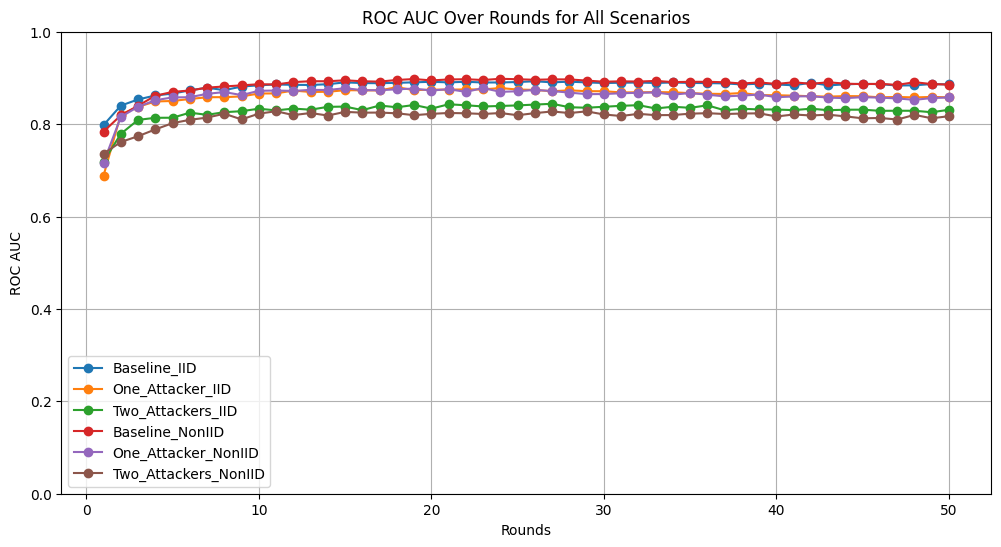

In [ ]:
# Plot ROC AUC Over Rounds for All Scenarios
plt.figure(figsize=(12, 6))

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        plt.plot(df['rounds'], df['roc_auc'], marker='o', label=scenario)

plt.title('ROC AUC Over Rounds for All Scenarios')
plt.xlabel('Rounds')
plt.ylabel('ROC AUC')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Create a summary table of final metrics for all scenarios
summary_metrics = []

for scenario in scenarios:
    if scenario in dataframes:
        df = dataframes[scenario]
        final_round = df['rounds'].max()
        final_metrics = df[df['rounds'] == final_round].iloc[0]
        summary_metrics.append({
            'Scenario': scenario,
            'Final Round': final_round,
            'Accuracy': final_metrics['accuracy'],
            'Kappa': final_metrics['kappa'],
            'F1 Score': final_metrics['f1_score'],
            'ROC AUC': final_metrics['roc_auc']
        })

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary_metrics)

# Display the summary table
print("Summary of Final Metrics for All Scenarios:")
display(summary_df)


Summary of Final Metrics for All Scenarios:


,Scenario,Final Round,Accuracy,Kappa,F1 Score,ROC AUC
0,Baseline_IID,50,0.625200,0.583438,0.624924,0.885833
1,One_Attacker_IID,50,0.582200,0.535649,0.583770,0.857949
2,Two_Attackers_IID,50,0.459000,0.399169,0.449820,0.831102
3,Baseline_NonIID,50,0.633420,0.580755,0.566621,0.885652
4,One_Attacker_NonIID,50,0.578453,0.519801,0.520462,0.857738
5,Two_Attackers_NonIID,50,0.406156,0.327463,0.351096,0.817203


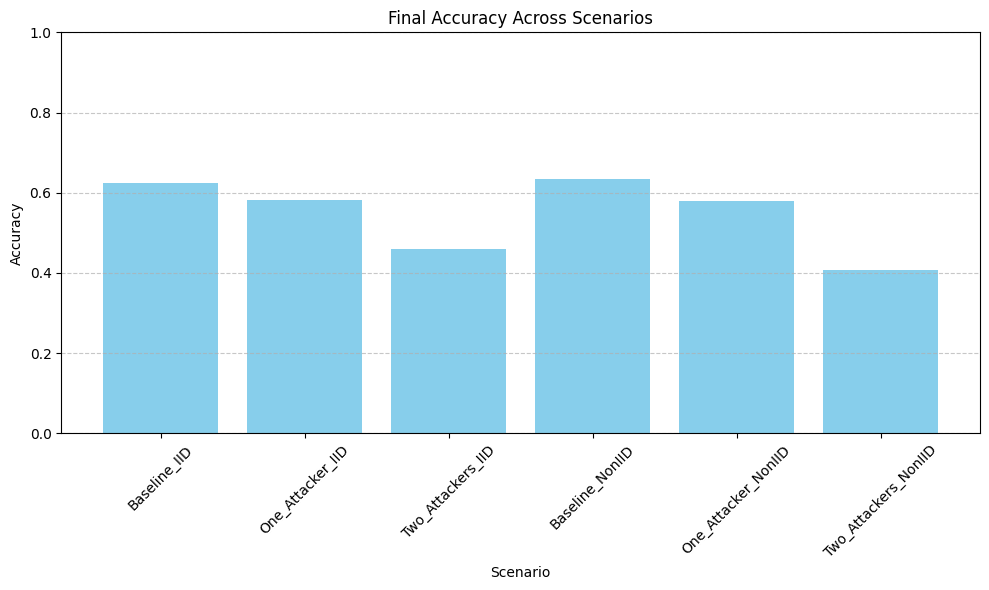

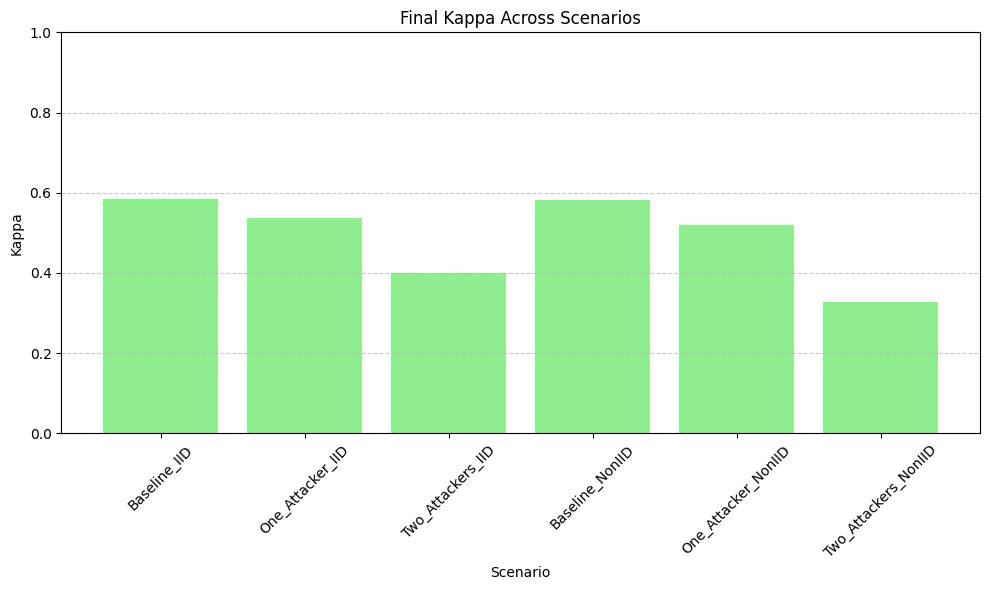

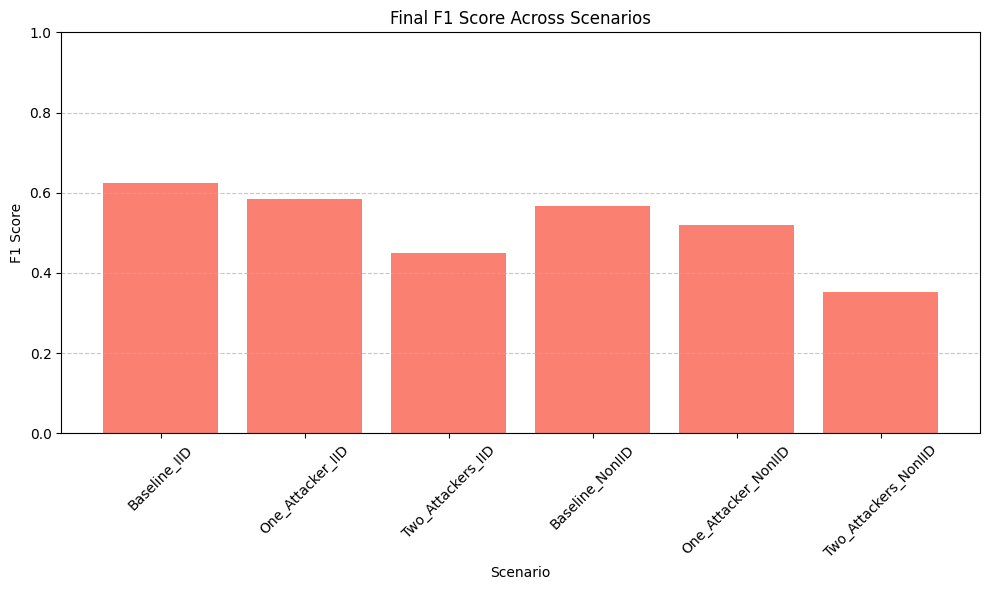

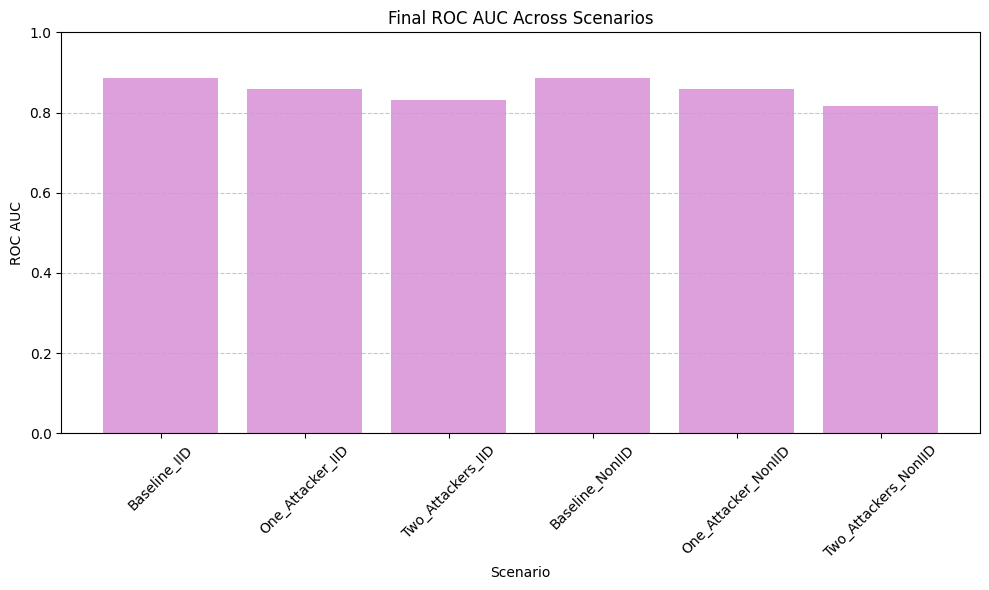

In [ ]:
# Plot bar charts to compare final metrics across scenarios

metrics = ['Accuracy', 'Kappa', 'F1 Score', 'ROC AUC']
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']

for metric, color in zip(metrics, colors):
    plt.figure(figsize=(10, 6))
    plt.bar(summary_df['Scenario'], summary_df[metric], color=color)
    plt.title(f'Final {metric} Across Scenarios')
    plt.xlabel('Scenario')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
